In [31]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch as t
import torchvision.transforms as T #torchvision.transforms provides common image transformations.
import numpy as np
import pickle
from sklearn.preprocessing import OneHotEncoder
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform
import matplotlib.pyplot as plt
import warnings
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import torch.optim.lr_scheduler as lr_scheduler


warnings.filterwarnings("ignore")

In [2]:
cd = os.getcwd()
train = pd.read_csv(cd+'/train.csv')
test = pd.read_csv(cd+'/test.csv')
train.head()

,article_id,garment_types,brand,Fabric,Pattern,Collar,Fastening,Neckline,Shape,Length,Fit,Color,sample
0,ON321C1Q3-G11,casual_dress,ONLY,Missing,Plain,Missing,Missing,Square neck,Fitted,Knee-length,Regular Fit,Brown,train
1,VM321C0XY-K11,casual_dress,Vera Mont,Jersey,Plain,Standing collar,Zip,Square neck,Fitted,Knee-length,Regular Fit,Blue,train
2,P1421C0Y2-Q11,knitted_dress,Patrizia Pepe,Knit,Plain,Missing,Laces,Backless,Fitted,Short,Slim Fit,Black,train
3,BB121C0XQ-Q11,shirt_dress,BOSS,Missing,Plain,Turn-down collar,Drawstring fastening,Missing,Fitted,Knee-length,Regular Fit,Black,train
4,Y0121C2MD-A11,casual_dress,YAS,Missing,Plain,Missing,Laces,Cache-coeur,Fitted,Short,Regular Fit,Beige,train


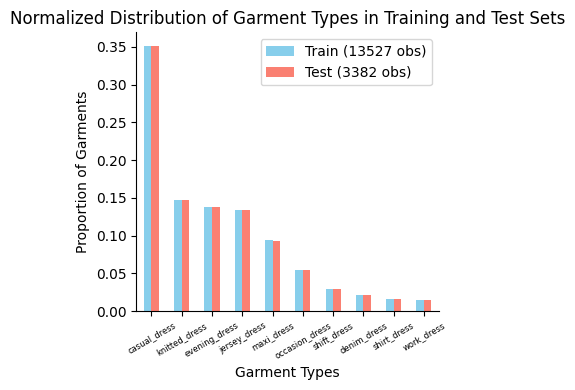

In [3]:
# prepare
garment_train = train['garment_types'].value_counts().sort_values(ascending=False)
garment_test = test['garment_types'].value_counts().sort_values(ascending=False)

# normlaize
garment_train_normalized = garment_train / garment_train.sum()
garment_test_normalized = garment_test / garment_test.sum()

# combine
df_normalized = pd.DataFrame({'Train': garment_train_normalized,
                              'Test': garment_test_normalized}).fillna(0)

# plot
fig, ax = plt.subplots(figsize=(4, 4))
df_normalized.plot(kind='bar', ax=ax, color=['skyblue', 'salmon'])
ax.spines[['top', 'right']].set_visible(False)
ax.set_ylabel('Proportion of Garments')
ax.set_xlabel('Garment Types')
ax.set_title('Normalized Distribution of Garment Types in Training and Test Sets')
ax.legend([f'Train ({garment_train.sum()} obs)', f'Test ({garment_test.sum()} obs)'])
plt.xticks(rotation=30, size=6)
plt.tight_layout()
plt.show()

In [4]:
# Load the pre-trained DinoV2 model
dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")
# Set the device to GPU if available, otherwise use CPU
device = torch.device('mps' if torch.cuda.is_available() else "cpu")
dinov2_vits14.to(device)

def res(image, change=14): # resize the image to fit the necessary inputs for dino (patch with white)
    w, h = image.size
    max_d = max(w, h)
    new_w = (max_d // change) * change
    new_h = (max_d // change) * change
    resized = Image.new("RGB", (max_d, max_d), color=(255, 255, 255))  # background
    resized.paste(image, ((max_d - w) // 2, (max_d - h) // 2))  # input original image
    return resized.resize((new_w, new_h))  # resize

Using cache found in /Users/josh/.cache/torch/hub/facebookresearch_dinov2_main


# ---------------------------------------------------------------------------

# DO NOT RUN AGAIN - 20 MINUTES

In [ ]:
folder = 'raw/'
# transform_image = T.Compose([T.ToTensor(), T.Resize(224), T.Normalize([0.5], [0.5])])
transform_image = T.Compose([T.Resize(224), T.CenterCrop(224), T.ToTensor(), T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

image_names = []
total_features = []

with torch.no_grad():
    for image in os.listdir(folder):
        if image.lower().endswith(('.jpg', '.jpeg', '.png', '.gif')):
                image_path = os.path.join(folder, image)
                img = Image.open(image_path)
                img_res = res(img)
                image_tensor = transform_image(img_res).to(device)
                dino_embedding = dinov2_vits14(image_tensor.unsqueeze(0))
                total_features.append(dino_embedding)
                image_names.append(os.path.splitext(image)[0])

total_features_np = [feature.numpy().flatten() for feature in total_features]
image_fea = pd.DataFrame({'article_id': image_names, 'features': total_features_np})

with open('image_fea.pkl', 'wb') as f:
    pickle.dump(image_fea, f)

# ---------------------------------------------------------------------------

## Load and reformat the features

In [5]:
with open('image_fea.pkl', 'rb') as f:
    image_fea_loaded = pickle.load(f)
    
df_train = pd.merge(train, image_fea_loaded, on='article_id', how='inner').dropna(subset=['features'])
df_test = pd.merge(test, image_fea_loaded, on='article_id', how='inner').dropna(subset=['features'])

## get features from image, one-hot-encode the other features and the target variables and split the data

In [6]:
def preprocess(train_data, test_data):
    
    # features from images
    features_train1 = train_data['features']
    features_train1_df = pd.DataFrame(np.stack(features_train1))

    # features from csv
    features_train2 = train_data.drop(columns=['article_id', 'features', 'garment_types'])
    enc = OneHotEncoder(handle_unknown='ignore')
    features_train2_enc = enc.fit_transform(features_train2)
    features_train2_df = pd.DataFrame.sparse.from_spmatrix(features_train2_enc)
    new_train = {i: i + 1000 for i in features_train2_df.columns}
    features_train2_df2 = features_train2_df.rename(columns=new_train)
    
    # features from images
    features_test1 = test_data['features']
    features_test1_df = pd.DataFrame(np.stack(features_test1))  

    # features from csv
    features_test2 = test_data.drop(columns=['article_id', 'features', 'garment_types'])
    features_test2_enc = enc.transform(features_test2)
    features_test2_df = pd.DataFrame.sparse.from_spmatrix(features_test2_enc)
    new_test = {i: i + 1000 for i in features_test2_df.columns}
    features_test2_df2 = features_test2_df.rename(columns=new_test)
    
    # connect features
    x_train_df = pd.concat([features_train1_df, features_train2_df2], axis=1)
    x_test_df = pd.concat([features_test1_df, features_test2_df2], axis=1)
  

    # one hot encode ouptputs
    enc_y = OneHotEncoder(handle_unknown='ignore')
    y_df_tr = train_data['garment_types'].values.reshape(-1, 1)
    y_train_df = enc_y.fit_transform(y_df_tr).toarray()

    y_df_te = test_data['garment_types'].values.reshape(-1, 1)
    y_test_df = enc_y.transform(y_df_te).toarray()
  
    return x_train_df, x_test_df, y_train_df, y_test_df, enc_y

x_train_df, x_test_df, y_train_df, y_test_df, enc_y = preprocess(df_train, df_test)
print("Shape of training features after one hot encoding: ", x_train_df.shape)
print("Shape of testing features after one hot encoding: ", x_test_df.shape)
print("Shape of training output after one hot encoding: ", y_train_df.shape)
print("Shape of testing ouput data after one hot encoding: ", y_test_df.shape)

Shape of training features after one hot encoding:  (13527, 1134)
Shape of testing features after one hot encoding:  (3382, 1134)
Shape of training output after one hot encoding:  (13527, 10)
Shape of testing ouput data after one hot encoding:  (3382, 10)


## Prepare the sets and loaders for the neural network

In [7]:
def prepare(train_data, test_data, train):
    
    x_train_df, x_test_df, y_train_df, y_test_df, enc_y = preprocess(train_data, test_data)

    if train: # if in training
       x_train, x_val, y_train, y_val = train_test_split(x_train_df.values, y_train_df, test_size=0.1, random_state=42)
       X_train = t.tensor(x_train, dtype=t.float32)
       Y_train = t.tensor(y_train, dtype=t.float32)  
       X_val = t.tensor(np.array(x_val.tolist()), dtype=t.float32)
       Y_val = t.tensor(np.array(y_val.tolist()), dtype=t.float32)
       train_set = data.TensorDataset(X_train, Y_train)
       val_set = data.TensorDataset(X_val, Y_val)
       train_loader = data.DataLoader(train_set, batch_size=10, shuffle=True)
       valid_loader = data.DataLoader(val_set, batch_size=10, shuffle=False)
       return train_loader, valid_loader, X_train, Y_train, X_val, Y_val, enc_y
    
    else: # if in testiing
       X_test = t.tensor(x_test_df.values, dtype=t.float32)
       Y_test = t.tensor(y_test_df, dtype=t.float32)  
       test_set = data.TensorDataset(X_test, Y_test)
       test_loader = data.DataLoader(test_set, batch_size=10, shuffle=False)
       return test_loader, X_test, Y_test, enc_y

train_loader, valid_loader, X_train, Y_train, X_val, Y_val, enc_y = prepare(df_train, df_test, True)
test_loader, X_test, Y_test, enc_y = prepare(df_train, df_test, False)

## Create the neural net

In [8]:
device = torch.device('cuda')

class Model(nn.Module): # creates the neural net with various possibilities of input
    def __init__(self, size_in, hidden, size_out):
        super(Model, self).__init__()
        layers = []
        current = size_in
        for out in hidden:
            layers.append(nn.Linear(current, out))
            layers.append(nn.ReLU())
            current = out
        layers.append(nn.Linear(current, size_out))
        layers.append(nn.Softmax())
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net (x)

size_in = 1134
hidden = [100, 50, 25]
size_out = 10
model = Model(size_in, hidden, size_out)
print(model)

Model(
  (net): Sequential(
    (0): Linear(in_features=1134, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=25, bias=True)
    (5): ReLU()
    (6): Linear(in_features=25, out_features=10, bias=True)
    (7): Softmax(dim=None)
  )
)


## Do a wide randomized search on a lot of hyper parameters
I tried various inputs previously and found these areas to be the most promising. Therefore I continue in this direction.
I am aware that it is not the BEST way as optimally there would be an even wider search of parameters.
However my computing power is limited.

In [ ]:
# reformat for the RandomizedSearchCV as it doesnt take one-hot-encoded outputs
Y_train_temp = torch.tensor(Y_train, dtype=torch.long)
Y_train_temp = np.argmax(Y_train, axis=1) if Y_train.ndim > 1 else Y_train

# initiate
net = NeuralNetClassifier(Model, module__size_in=1134, module__hidden=[20, 10], module__size_out=10, optimizer=optim.Adam,
    criterion=nn.CrossEntropyLoss, max_epochs=10, lr=0.01, batch_size=32, iterator_train__shuffle=True,)

# some parameters
hidden = [[200], [400], [200, 400], [20, 50, 100], [50, 100, 200]]
lr = np.random.uniform(0.00001, 0.0005, 5)
params = {'lr': lr, 'module__hidden': hidden,  'batch_size': [9, 10, 11], 'max_epochs': [10, 50]}

# random search
random_search = RandomizedSearchCV(estimator=net, param_distributions=params, n_iter=5, cv=3, scoring='accuracy', verbose=1, n_jobs=-1, random_state=42)
search = random_search.fit(X_train, Y_train_temp)

In [12]:
print("Best parameters found: ", search.best_params_)
print("Best accuracy found: ", search.best_score_)

Best parameters found:  {'module__hidden': [400], 'max_epochs': 50, 'lr': 0.0004634462171054758, 'batch_size': 10}
Best accuracy found:  0.6934450468210941


## Do a fine grained grid search around the so far optimal parameters
Narrowing down on the previously good parameters.

In [ ]:
net = NeuralNetClassifier(Model, module__size_in=1134, module__hidden=[400], module__size_out=10, optimizer=optim.Adam,
    criterion=nn.CrossEntropyLoss, max_epochs=10, lr=0.01, batch_size=10, iterator_train__shuffle=True,)

param_grid = {'lr': [0.00007, 0.0001, 0.0002, 0.0004, 0.0005], 'max_epochs': [45, 55],}
grid_search = GridSearchCV(estimator=net, param_grid=param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
grid_search.fit(X_train, Y_train_temp)

In [15]:
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)

Best parameters found:  {'lr': 7e-05, 'max_epochs': 55}
Best accuracy found:  0.710119927714802


## optimal model

In [16]:
from skorch import NeuralNetClassifier
net = NeuralNetClassifier(Model, module__size_in=1134, module__hidden=[400], module__size_out=10, optimizer=optim.Adam,
    criterion=nn.CrossEntropyLoss, max_epochs=10, lr=0.00007, batch_size=10, iterator_train__shuffle=True,)

## Function for evaluation
It will be used in the evaluation phase of the training, as well as in the testing phase.

In [18]:
class_labels = sorted(set(enc_y.inverse_transform(np.unique(Y_test.detach().numpy(), axis=0)).flatten()))

def evaluate_model(net, test_load):
    net.eval() 
    lossf = nn.CrossEntropyLoss()
    loss, loss_arr, val_accuracies, true_labs, pred_labs = [], [], [], [], []
    
    with t.no_grad():
            for x_val, y_val in test_load:
                val_pred = net(x_val)
                val_loss = lossf(val_pred, y_val)
                loss.append(val_loss.item())
                pred = t.argmax(val_pred, dim=1)
                true = t.argmax(y_val, dim=1)
                accuracy = (pred == true).float().mean().item()
                val_accuracies.append(accuracy)
                pred_labs.extend(pred.numpy())
                true_labs.extend(true.numpy())

            valid_loss = np.mean(loss)
            accuracy = np.mean(val_accuracies)  

    conf_matrix = confusion_matrix(true_labs, pred_labs)
    report = classification_report(true_labs, pred_labs, target_names=class_labels)

    return valid_loss, accuracy, conf_matrix, report

loss, acc, conf, rep = evaluate_model(Model(1134,[20],10), test_loader)

## Training the model

In [19]:
def early_stop(losses, thresh=1e-4): # checks if the losses stop becoming smaller
    if len(losses) < 20:
        return False
    recent = losses[-10:]
    previous = losses[-20:-10]
    recent_m = np.mean(recent)
    previous_m = np.mean(previous)
    improvement = previous_m - recent_m
    return improvement < thresh

def plot_losses(train_losses, val_losses, epo): # plots the losses
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Training and Validation Loss (stopped at epoch {epo})')
    plt.legend()
    plt.grid(True)
    plt.show()

Epoch 5/100, Train Loss: 1.8735, Valid Loss: 1.8873, Accuracy: 0.5779
Epoch 10/100, Train Loss: 1.7942, Valid Loss: 1.8218, Accuracy: 0.6483
Epoch 15/100, Train Loss: 1.7540, Valid Loss: 1.7930, Accuracy: 0.6821
Epoch 20/100, Train Loss: 1.7316, Valid Loss: 1.7801, Accuracy: 0.6917
Epoch 25/100, Train Loss: 1.7195, Valid Loss: 1.7750, Accuracy: 0.7012
Epoch 30/100, Train Loss: 1.7123, Valid Loss: 1.7634, Accuracy: 0.7145
Epoch 35/100, Train Loss: 1.7027, Valid Loss: 1.7576, Accuracy: 0.7196
Epoch 40/100, Train Loss: 1.6982, Valid Loss: 1.7552, Accuracy: 0.7196
Epoch 45/100, Train Loss: 1.6954, Valid Loss: 1.7551, Accuracy: 0.7225
Epoch 50/100, Train Loss: 1.6946, Valid Loss: 1.7546, Accuracy: 0.7233
Epoch 55/100, Train Loss: 1.6936, Valid Loss: 1.7543, Accuracy: 0.7218
Epoch 60/100, Train Loss: 1.6929, Valid Loss: 1.7539, Accuracy: 0.7233
Epoch 65/100, Train Loss: 1.6924, Valid Loss: 1.7540, Accuracy: 0.7240
Epoch 70/100, Train Loss: 1.6922, Valid Loss: 1.7540, Accuracy: 0.7240
Epoch 7

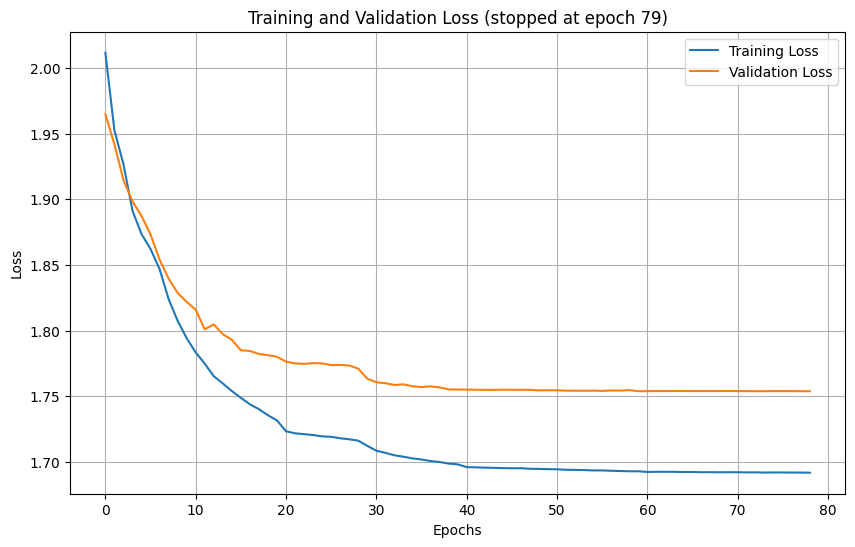

In [57]:
device = t.device('mps')

def train_model(train_loader, valid_loader, hidden, lr, epochs):
    net = Model(1134, hidden, 10)
    lossf = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=lr)
    loss_arr_train, loss_arr_valid = [], []
    scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.2)

    for epoch in range(epochs):
        # Training
        net.train()
        loss_t = []
        for x, y in train_loader:
            pred = net(x)
            loss = lossf(pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_t.append(loss.item())
        train_loss = np.mean(loss_t)
        loss_arr_train.append(train_loss)
        # Evaluating
        valid_loss, accuracy, conf, rep = evaluate_model(net, valid_loader) # net.eval() happens in evaluate function
        loss_arr_valid.append(valid_loss)
        if early_stop(loss_arr_valid):
            print(f"Early stopping at epoch {epoch}")
            break
        if (epoch + 1) % 5 == 0: 
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Accuracy: {accuracy:.4f}')
        
        scheduler.step()

    print("Finished Training")
    plot_losses(loss_arr_train, loss_arr_valid, epoch+1)
    return net

hidden = [400]
lr = 0.00004 # 0.7343 at 70

epochs = 100
trained_model = train_model(train_loader, valid_loader, hidden, lr, epochs)

## Analysis of Testset, Confusion Matrix and Report
The confusion matrix shows that it does quite well alltogether. Most missclassifications include the casual dress, which due to it's predominance is no surprise. Most predicted a certain type, were actually true and can be seen on the main diagonal.

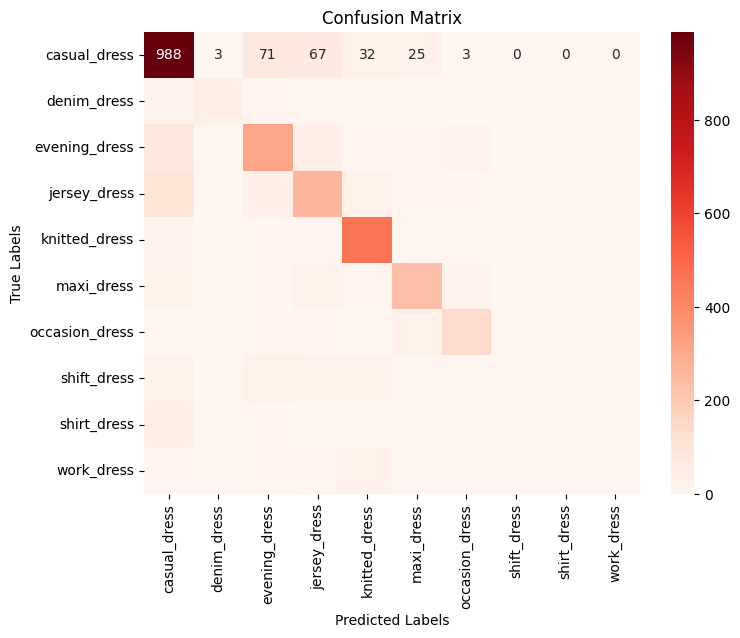

                precision    recall  f1-score   support

  casual_dress       0.76      0.83      0.79      1189
   denim_dress       0.86      0.61      0.72        72
 evening_dress       0.63      0.67      0.65       467
  jersey_dress       0.60      0.59      0.59       453
 knitted_dress       0.79      0.93      0.85       497
    maxi_dress       0.74      0.73      0.74       316
occasion_dress       0.74      0.75      0.75       186
   shift_dress       0.00      0.00      0.00        99
   shirt_dress       0.00      0.00      0.00        53
    work_dress       0.00      0.00      0.00        50

      accuracy                           0.72      3382
     macro avg       0.51      0.51      0.51      3382
  weighted avg       0.68      0.72      0.70      3382



In [58]:
loss, acc, conf, rep = evaluate_model(trained_model, test_loader)
class_labels = enc_y.inverse_transform(np.unique(Y_test.detach().numpy(), axis=0))
class_labels = sorted(set(class_labels.flatten()))
plt.figure(figsize=(8, 6))
sns.heatmap(conf, annot=True, fmt="d", cmap="Reds", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
print(rep)

Overall accuracy of 72 percent is pretty good, given limited computational power. High precision in denim dresses indicates that my model is good at correctly predicting this dress, when it does. For casual and knitted dresses, recall is quite high indicating that the model catches these dresses very well.
For the other dresses, the model performs adequatly. Only shift, shirt, and work dress is where the limitations lie and the model fails to identify them.
F1 score is the best for knitted dress which probably due to its very high recall of 0.93.


## Analysis of 10 specific items
This code generates a random sample of 10 items from the test set and predicts their garment type.
Then it adds them and some more information to a temporary dataframe for further analysis.

In [60]:
test_set = data.TensorDataset(X_test, Y_test)
random = torch.randperm(len(test_set))[:10]
ind = random.tolist()
subset = data.Subset(test_set, random)
test_loader_10 = data.DataLoader(subset, batch_size=10, shuffle=False)

for x,y in test_loader_10:
     pred = trained_model(x)
     pred_final = t.argmax(pred, dim=1)
     sol = (pred_final == t.argmax(y, dim=1))

predictions = enc_y.inverse_transform(pred.detach().numpy())
df_10 = df_test.iloc[ind]
df_10['pred'] = predictions
df_10['correct'] = sol
image_paths = [os.path.join('raw', article_id + ".jpg") for article_id in df_10['article_id']]
df_10['paths'] = image_paths
df_10.head()

,article_id,garment_types,brand,Fabric,Pattern,Collar,Fastening,Neckline,Shape,Length,Fit,Color,sample,features,pred,correct,paths
1821,THA21C05Z-K11,evening_dress,The Kooples,Chiffon,Plain,Standing collar,Missing,Cache-coeur,Flared,Long,Regular Fit,Blue,train,"[-0.9314447, 0.9221961, -2.0354757, -0.2143388...",maxi_dress,False,raw/THA21C05Z-K11.jpg
2645,Y0121C2IA-I11,evening_dress,YAS,Other,Other,Missing,Missing,Cache-coeur,Fitted,Short,Loose Fit,Purple,val,"[-2.1384783, 1.260699, -1.8883325, 3.8858454, ...",evening_dress,True,raw/Y0121C2IA-I11.jpg
1846,VE121C3FL-Q11,knitted_dress,Vero Moda,Knit,Plain,Standing collar,Missing,Crew neck,Straight,Short,Slim Fit,Black,train,"[-4.19335, 1.0954089, 1.4312721, 0.44795382, -...",knitted_dress,True,raw/VE121C3FL-Q11.jpg
1170,SG721C0SY-D11,evening_dress,Swing,Jersey,Marl,Standing collar,Zip,Crew neck,Fitted,Calf-length,Slim Fit,Pink,train,"[0.8765171, 0.77764934, -1.9396989, 2.9451015,...",evening_dress,True,raw/SG721C0SY-D11.jpg
1338,AN621C21Y-Q11,shift_dress,Anna Field,Jersey,Print,Standing collar,Missing,Missing,Body-hugging,Knee-length,Skinny Fit,Grey,val,"[2.076741, 1.1567233, -0.29925704, 0.39192414,...",jersey_dress,False,raw/AN621C21Y-Q11.jpg


## create a nice image with some information

In [61]:
font = ImageFont.load_default()
image_paths = df_10['paths'].to_numpy()

def get_image(path, true, pred, cor): # creates and resizes an image, an writes true/predicted 
 im = Image.open(path)
 a = res(im, change=14)
 b = a.resize((146, 211)) 
 w, h = b.width, b.height
 white = Image.new("RGB", (w+10, h+50), color="white")
 white.paste(b, (5, 5))
 grey = Image.new("RGB", (50, 20), color="lightgrey")
 white.paste(grey, (5, 5))
 draw = ImageDraw.Draw(white)
 draw.text((w/2, h+20), 'Actual:        ' + true, fill="black", font=font, anchor='ms')
 draw.text((w/2, h+30), 'Predicted: ' + pred, fill="black", font=font, anchor='ms')
 col ="red"
 if cor:
    col = "green"
 draw.text((30, 19), str(cor), fill=col, font=font, anchor='ms')
 return white



## connect 10 of images of the sample of 10

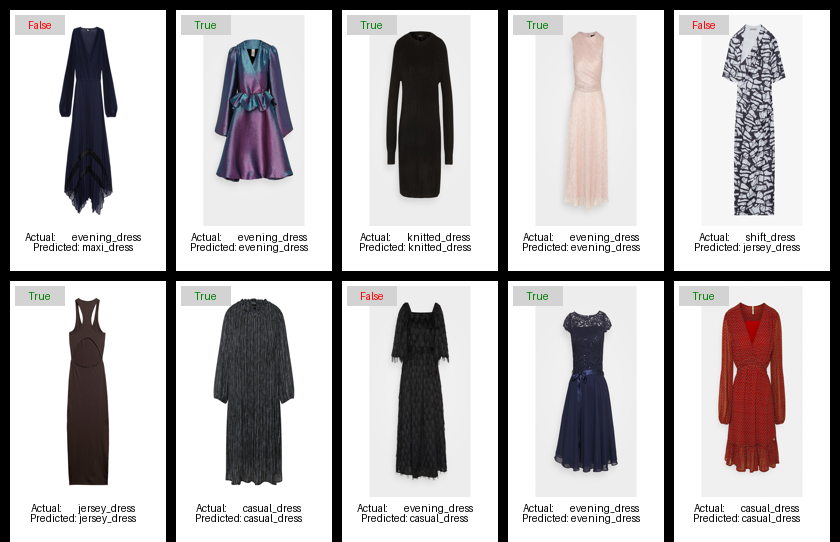

In [62]:
def connect_images(df): # connects all the images onto a canvas

    # get arrays
    image_paths = df_10['paths'].to_numpy()
    true = df_10['garment_types'].to_numpy()
    pred = df_10['pred'].to_numpy()
    correct = df_10['correct'].to_numpy()
    
    # prepare main canvas
    im = get_image(image_paths[1], true[1], pred[1], correct[1])
    w, h = im.width, im.height
    entire = Image.new("RGB", ((w+10)*5 + 10, (h+10)*2), color="black")
    f = 10
    r = 10
    placed = 0

    # add the selected images
    for i in range(0,10):
        im = get_image(image_paths[i], true[i], pred[i], correct[i])
        entire.paste(im, (f, r))
        f += w + 10
        placed += 1
        if placed == 5:
            f = 10
            r += h + 10

    return entire

connect_images(image_paths)

These are 10 random dresses with their respective predictions. Solely from these it again shows that the model has difficulties predicting evening dresses.
Given precision of 0.67 this must just be an unlucky sample. 
It looks like the evening dresses are also more often darker, which might be a good feature to annotate manually.
While dinoV2 catches the pixels, the size of the dress influences the amount of coloured pixels.
This could possibly be the reason why it missclassifies these.
Other than that the wrongfully predicted jersery dress could be due to it's pattern.
This could hold similarities to other jersey dresses which might cause the mixup.
Nonetheless I believe that the model could need some additional features to properly improve.